In [9]:
import pygmt 
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
import warnings
import os
import glob
import sys
import sdc
from obspy import UTCDateTime,geodetics
warnings.filterwarnings('ignore')

In [10]:
# read the catalog
datadir = 'TGR_data/tomoDD09/RealDataInversion/Output_Files'
names = ['evtid','latitude','longitude','depth','X','Y','Z','ex','ey','ez',
         'year','month','day','hour','minute','second','magnitude',
         'nccp','nccs','nctp','ncts','rcc','rct','cid']
reloc = pd.read_csv(f'{datadir}/tomoDD.reloc',sep='\s+',names=names)
#reloc = pd.read_csv('TGR_data/tomoDD-SE/TGR_2020/0.03_12/RealDataInversion/Output_Files/tomoDD.reloc',sep='\s+',names=names)

names = ['evtid','latitude','longitude','depth','X','Y','Z','ex','ey','ez',
         'year','month','day','hour','minute','second','magnitude','cid']
loc = pd.read_csv(f'{datadir}/tomoDD.loc',sep='\s+',names=names)
#loc = pd.read_csv('TGR_data/tomoDD-SE/TGR_2020/0.03_12/RealDataInversion/Output_Files/tomoDD.loc',sep='\s+',names=names)
cities = pd.read_csv('TGR_data/geology/SX_citylonlat.txt',sep='\s+',encoding='gbk')
# read the gCAp
names=['x','y','longitude','latitude','depth','strike1','dip1','rake1','strike2','dip2','rake2',
       'magnitude','exp','plot_longitude','plot_latitude','name','label','time']
meca = pd.read_csv('TGR_data/gCAP/SanxiagCAP.gcmt',sep='\s+',skiprows=8,names=names)
meca

,x,y,longitude,latitude,depth,strike1,dip1,rake1,strike2,dip2,rake2,magnitude,exp,plot_longitude,plot_latitude,name,label,time
0,-7.484448,10.156138,110.424116,31.090811,5.2,168,84,37,69,49,169,4.75,23,110:10,30:43,2013/12/16,Eq3,2013-12-16T13:04:51.616673Z
1,26.788592,-8.601576,110.791288,30.919061,6.5,341,60,52,139,68,12,4.38,23,110:30,30:43,2014/03/30,Eq2,2014-03-30T00:24:44.771455Z
2,26.697288,-8.334921,110.791276,30.915888,7.7,140,67,0,142,76,23,4.17,23,110:40,30:43,2014/03/27,Eq1,2014-03-27T00:20:04.877267Z


In [11]:
t1 = UTCDateTime('2009/3/1')
t2 = UTCDateTime('2010/12/17')
for i in range(len(reloc)):
    line  = reloc.iloc[i]
    time = UTCDateTime(int(line.year),int(line.month),int(line.day),int(line.hour),int(line.minute),0)+line.second
    reloc.loc[line.name,'time'] =  time
    reloc.loc[line.name,'reltime'] = (time-t1)/(1*24*60*60)

In [12]:
# read mod
model = xr.open_dataset('TGR_data'+os.sep+'tomoDD09'+os.sep+'TGR_2009_velocity_3_19.h5')
grid_x,grid_y,grid_z = model.longitude.values,model.latitude.values,model.depth.values
grid_xy = np.meshgrid(grid_x,grid_y)
grid_xz = np.meshgrid(grid_x,grid_z)
grid_zy = np.meshgrid(grid_z,grid_y)


In [13]:
def read_qml(qmlfile):
    lines = open(qmlfile,'r').readlines()
    geo_categories = {}
    for line in lines:
        tmp = line.strip().split()
        if tmp[0] == '<category':
            symbol = [a for a in tmp if a.find('symbol') >= 0][0].split('"')[1]
            name = [a for a in tmp if a.find('value') >= 0][0].split('"')[1]
            label = [a for a in tmp if a.find('label') >= 0][0].split('"')[1]
            label = label.replace('&lt;sup>','@+').replace('&lt;/sup>','@+').replace('&lt;sub>','@-').replace('&lt;/sub>','@-')
            geo_categories.setdefault(symbol,{}).setdefault('name',name)
            geo_categories.setdefault(symbol,{}).setdefault('label',label)
            if symbol == '':continue
        if tmp[0] == '<symbol':
            symbol = [a for a in tmp if a.find('name') >= 0][0].split('"')[1]
            if symbol == '':continue
        if line.find('<Option') >=0 and line.find('name="color"') >= 0 and symbol != '':
            color = [a for a in tmp if a.find('value') >= 0][0].split('"')[1].split(',')
            c = '/'.join([color[0],color[1],color[2]])
            geo_categories[symbol].setdefault('color',c)
    geo_strata = {}
    for i,symbol in enumerate(list(geo_categories)):
        name = geo_categories[symbol]['name']
        label = geo_categories[symbol]['label']
        color = geo_categories[symbol]['color']
        geo_strata.setdefault(name,{}).setdefault('name',name)
        geo_strata.setdefault(name,{}).setdefault('label',label)
        geo_strata.setdefault(name,{}).setdefault('color',color)
    return geo_categories,geo_strata   

In [14]:
def plot_stratum(fig):
    fig.plot(data='TGR_data/geology/Permian.gmt',pen='0.1p',fill='247/207/138',close=True)
    fig.plot(data='TGR_data/geology/Triassic.gmt',pen='0.1p',fill='240/191/212',close=True)
    fig.plot(data='TGR_data/geology/Permian_sub.gmt',pen='0.1p',fill='247/207/138',close=True)
    fig.plot(data='TGR_data/geology/Presinian.gmt',pen='0.1p',fill='240/143/117',close=True)
    fig.plot(data='TGR_data/geology/Jurassic.gmt',pen='0.1p',fill='181/204/227',close=True)
    # plot the fault
    fig.plot(data='TGR_data/geology/Faults.gmt',pen='0.5p,red')
    # mark the location of TGR
    fig.plot(data=[[111.00376,30.823633,43,1,0.1]],style='j',fill='black',no_clip=True)
    #fig.text(x=111.00376,y=30.823633,text='TGD',font='10p,6,black',justify='MC',offset='-0.1c/-0.5c',fill='lightblue')
def plot_H4909(fig):
    # read the geological data
    file = 'TGR_data/geology/H4909.gpkg'
    H4909 = gpd.read_file(file, layer='strata').set_crs('EPSG:4326')
    faults = gpd.read_file(file, layer='faults_main').set_crs('EPSG:4326')
    # 清洗数据
    geology = H4909.copy()
    for i in range(len(H4909)):
        data = H4909.iloc[i]
        if data.geometry.is_empty:
            geology = geology.drop(index=i)
    geo_categories = {'Q':{'name':'Q','label':'Q','color':'255/248/128'},
                    'K':{'name':'K','label':'K','color':'128/207/92'},
                    'J':{'name':'J','label':'J','color':'51/189/233'},
                    'T':{'name':'T','label':'T','color':'138/62/164'},
                    'P':{'name':'P','label':'P-Cm','color':'231/77/64'},
                    'Pt':{'name':'Pt','label':'Presinian','color':'240/143/117'}}
    geo_categories = {'Q':{'name':'Q','label':'Quaternary','color':'255/248/128'},
                    'K':{'name':'K','label':'Cretaceous','color':'128/207/92'},
                    'J':{'name':'J','label':'Jurassic','color':'181/204/227'},
                    'P':{'name':'P','label':'Permian-Cambrian','color':'247/207/138'},
                    'T':{'name':'T','label':'Triassic','color':'240/191/212'},
                    'Pt':{'name':'Pt','label':'Precambrian','color':'240/143/117'}}
    for i,name in enumerate(list(geo_categories)):
        array = geology[geology.DSO == name]
        color = geo_categories[name]['color']
        label = geo_categories[name]['label']
        fig.plot(data=array,pen='0.1p',fill=color,close=True)
    # plot the fault
    fig.plot(data='TGR_data/geology/Faults.gmt',pen='0.5p,red')
def plot_Badong(fig):
    # read qml
    file = 'E:\\DoctorWorkspace\\Papers\\tomoDD-TGR\\geology_map\\H49E006010.qml'
    geo_categories,geo_strata = read_qml(qmlfile=file)

    file = 'E:\\DoctorWorkspace\\Papers\\tomoDD-TGR\\geology_map\\H49E006010.gpkg'
    H4909 = gpd.read_file(file, layer='strata').set_crs('EPSG:4326')
    faults = gpd.read_file(file, layer='faults').set_crs('EPSG:4326')

    geology = H4909[['name','geometry']].copy()
    # 清洗数据
    geo = geology.copy()
    for i in range(len(geology)):
        data = geology.iloc[i]
        if data.geometry.is_empty:
            geo = geo.drop(index=i)
    fault = faults.copy()
    for i in range(len(faults)):
        data = faults.iloc[i]
        if data.geometry.is_empty:
            fault = fault.drop(index=i)
    # plot the stratum
    for i,name in enumerate(list(geo_strata)):
        array = geo[geo.name == name]
        color = geo_strata[name]['color']
        label = geo_strata[name]['label']
        fig.plot(data=array,pen='0.1p',fill=color,close=True,label=label)
    fig.plot(data=fault,pen='0.5p,red')
def plot_line(fig,p,label=['A1','A2'],offset=['0c/0c','0c/0c']):
    lon1,lat1,lon2,lat2 = p
    fig.plot(x=[lonA1,lonA2],y=[latA1,latA2],pen='1.0p,red,--')
    fig.text(x=lonA1,y=latA1,text=label[0],offset=offset[0],font='8p,4,red')
    fig.text(x=lonA2,y=latA2,text=label[1],offset=offset[1],font='8p,4,red')
def plot_profile_location(fig,P,label=['A','B'],offset=['0c/0c','0c/0c']):
    lon1,lat1,lon2,lat2 = P
    dist,az,baz = geodetics.gps2dist_azimuth(lat1=lat1,lon1=lon1,lat2=lat2,lon2=lon2)
    track = pygmt.project(data=None,center=[lon1,lat1],endpoint=[lon2,lat2],generate=0.01,unit=True)
    length = track.p.max()
    fig.plot(x=track.r,y=track.s,pen='0.5p,blue,--')
    fig.text(x=track.r.values[0],y=track.s.values[0],text=label[0],justify='BL',offset=offset[0],font='8p,blue',fill='white',no_clip=True)
    fig.text(x=track.r.values[-1],y=track.s.values[-1],text=label[1],justify='BR',offset=offset[1],font='8p,blue',fill='white',no_clip=True)
    data = [[(lon1+lon2)/2,(lat1+lat2)/2,az,length,2*width]]
    #fig.plot(data=data,style='J',pen='0.2p,--')
    return length

In [15]:
# A1A2
lon_A1,lat_A1 = 110.237923, 31.2254903
lon_A2,lat_A2 = 110.970744, 30.8196086
lat_A1,lon_A1 = sdc.redist(xkm=-26,ykm=27,olat=31.0,olon=110.5,rota=0)
lat_A2,lon_A2 = sdc.redist(xkm=40,ykm=-21,olat=31.0,olon=110.5,rota=0)
P_A = [lon_A1,lat_A1,lon_A2,lat_A2]

# B1B2
lon_B1,lat_B1 = 110.256,31.167
lon_B2,lat_B2 = 110.284,31.000
lat_B1,lon_B1 = sdc.redist(xkm=-47,ykm=18,olat=31.0,olon=110.5,rota=0)
lat_B2,lon_B2 = sdc.redist(xkm=40,ykm=18,olat=31.0,olon=110.5,rota=0)
P_B = [lon_B1,lat_B1,lon_B2,lat_B2]
width = 3

# B1-B2
lon_B1,lat_B1 = 110.029215, 31.0899
lon_B2,lat_B2 = 110.971183, 31.0899
#P_B = [lon_B1,lat_B2,lon_B2,lat_B2]
#fig.plot(x=[lonB1,lonB2],y=[latB1,latB2],pen='0.5p')
#fig.text(x=lonB1,y=latB1,text='B1',offset='+0.0i/-0.1i',fill='white')
#fig.text(x=lonB2,y=latB2,text='B2',offset='-0.1i/-0.1i',fill='white')

# C1C2
lon_C1,lat_C1 = 110+20/60,31.167 # long
lon_C2,lat_C2 = 110+23/60,31.000
#lon_C,lat_C = 110+20/60,31.0+10/60 # short
#lon_D,lat_D = 110+22/60,31.0+ 4/60
lat_C1,lon_C1 = sdc.redist(xkm=-47,ykm=9,olat=31.0,olon=110.5,rota=0)
lat_C2,lon_C2 = sdc.redist(xkm=40,ykm=9,olat=31.0,olon=110.5,rota=0)
P_C = [lon_C1,lat_C1,lon_C2,lat_C2]

# D1D2
lon_D1,lat_D1 = 110+24/60,31.167
lon_D2,lat_D2 = 110+27/60,31.000
lat_D1,lon_D1 = sdc.redist(xkm=-47,ykm=3,olat=31.0,olon=110.5,rota=0)
lat_D2,lon_D2 = sdc.redist(xkm=40,ykm=3,olat=31.0,olon=110.5,rota=0)
P_D = [lon_D1,lat_D1,lon_D2,lat_D2]

# E1E2
lon_G,lat_G = 110.44732,	31.02774	
lon_H,lat_H = 110.50011,	31.08003
lon_E1,lat_E1 = 110+25/60,31+0/60	
lon_E2,lat_E2 = 110+30/60,31+5/60

lon_E1,lat_E1 = 110.256,31.167
lon_E2,lat_E2 = 110.284,31.000
P_E = [lon_E1,lat_E1,lon_E2,lat_E2]

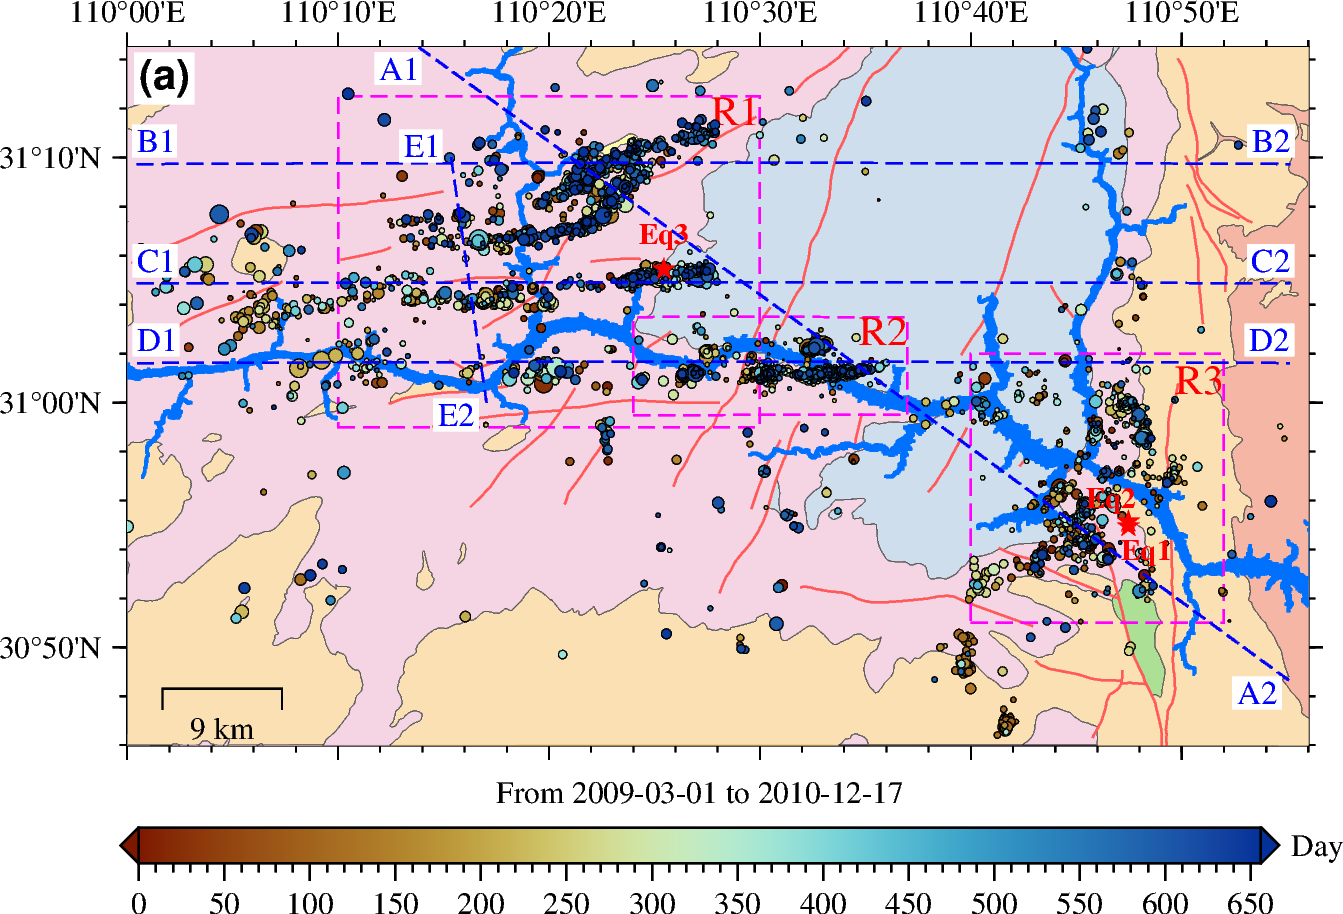

In [17]:
# plot the compare relocation
region = [110,110+56/60,30+46/60,31+14.5/60]
lon1,lon2,lat1,lat2 = region
#region = [110.25,110.5,31.0+2/60,31+12/60] # Badong
#region = [110+38/60,110+52/60,30+44/60,31+2/60] # Zigui
#region = [110+43/60,110+54/60,30+53/60,30+59/60] # zigui
#region = [110+24/60,110+36/60,30+59/60,31+3/60] # Xietan
fig = pygmt.Figure()
pygmt.config(FONT='7.5p,4',MAP_FRAME_TYPE='plain',MAP_FRAME_PEN='0.5p')
fig.basemap(region=region,projection='M10c',frame=['xaf','yaf','WseN'])
with pygmt.clib.Session() as session:
    with pygmt.helpers.GMTTempFile() as tmpfile:
        session.call_module("mapproject", f"-Wh ->{tmpfile.name}")
        map_height = tmpfile.read().strip()
map_height = float(map_height)

# plot the stratum
#plot_stratum(fig)
plot_H4909(fig)
#plot_Badong(fig)
fig.plot(x=[lon1,lon1,lon2,lon2,lon1],y=[lat1,lat2,lat2,lat1,lat1],fill='white@65')

# plot the rivers
fig.plot(data='TGR_data/geology/TGR.shp',pen='0.5p,0/112/255',fill='0/112/255',close=False)

# mark the location of TGR
#fig.plot(data=[[111.00376,30.823633,43,1,0.1]],style='j',fill='black',no_clip=True)
#fig.text(x=111.00376,y=30.823633,text='TGD',font='10p,6,black',justify='MC',offset='-0.2c/-0.5c',fill='lightblue')

# Badong
bregion = [110+10/60,110+30/60,31.0-1/60,31+12.5/60]
fig.plot(data=[[bregion[0],bregion[2],bregion[1],bregion[3]]],style='r+s',pen='0.5p,magenta,--')
fig.text(x=bregion[1],y=bregion[3],text='R1',justify='TR',font='10p,4,red')

# Xietan
xregion = [110+24/60,110+37/60,30+59.5/60,31+3.5/60]
fig.plot(data=[[xregion[0],xregion[2],xregion[1],xregion[3]]],style='r+s',pen='0.5p,magenta,--')
fig.text(x=xregion[1],y=xregion[3],text='R2',justify='TR',font='10p,4,red')

# Zigui
zregion = [110+40/60,110+52/60,30+51/60,31+2/60]
fig.plot(data=[[zregion[0],zregion[2],zregion[1],zregion[3]]],style='r+s',pen='0.5p,magenta,--')
fig.text(x=zregion[1],y=zregion[3],text='R3',justify='TR',font='10p,4,red',offset='0c/-0.1c')


pygmt.makecpt(cmap='roma',series=[0,reloc.reltime.max(),1],continuous=True,output='time.cpt')
fig.plot(x=reloc.longitude,y=reloc.latitude,style='cc',size=0.04*(reloc.magnitude+1),fill=reloc.reltime,cmap='time.cpt',pen='0.2p')
fig.colorbar(position='jBL+w9.5c/0.3c+o0.1c/-1.0c+ml+e+h',frame=['xa50f10+lFrom 2009-03-01 to 2010-12-17','y+lDay'],cmap='time.cpt')
#fig.plot(x=grid_xy[0].flatten(),y=grid_xy[1].flatten(),style='+0.02i',pen='0.2p,red')
# label grid
for lon in grid_x:
    lat = grid_y[0]
    xkm,ykm = sdc.dist(xlat=lat,xlon=lon,olat=31.0,olon=110.5,rota=0)
    #fig.text(x=lon,y=lat,text=round(xkm),font='7p,4,blue',justify='TC',offset='0c/-0.1c')
for lat in grid_y:
    lon = grid_x[-1]
    xkm,ykm = sdc.dist(xlat=lat,xlon=lon,olat=31.0,olon=110.5,rota=0)
    #fig.text(x=lon,y=lat,text=round(ykm),font='7p,4,blue',justify='ML',offset='0.1c/0c')
fig.basemap(map_scale='jBL+c110.5/31+w9+lkm+a+o0.3c/0.3c')

fig.text(position='cTL',text='(a)',font='10p,1',offset='j0.1c/0.1c',fill='white')

# profile
# A1A2
length_A = plot_profile_location(fig,P_A,label=['A1','A2'],offset=['-0.3c/-0.3c','-0.1c/-0.2c'])

# plot B1B2
length_B = plot_profile_location(fig,P_B,label=['B1','B2'],offset=['0c/0.1c','0c/0.1c'])

# plot C1C2
length_C = plot_profile_location(fig,P_C,label=['C1','C2'],offset=['0c/0.1c','0c/0.1c'])

# plot D1D2
length_D = plot_profile_location(fig,P_D,label=['D1','D2'],offset=['0c/0.1c','0c/0.1c'])

# plot E1E2
length_E = plot_profile_location(fig,P_E,label=['E1','E2'],offset=['-0.4c/0.0c','-0.1c/-0.2c'])

# plot meca
meca['plot_longitude'] = 110+26/60
meca['plot_latitude'] = 31+8/60
line = meca[meca.label=='Eq3']
cap = {'longitude':line.longitude,'latitude':line.latitude,'depth':line.depth,'magnitude':line.magnitude,'strike':line.strike1,'dip':line.dip1,'rake':line.rake1,'plot_longitude':line.plot_longitude,'plot_latitude':line.plot_latitude}
#fig.meca(spec=cap,scale='0.3c',convention='aki',offset=True)
#fig.plot(x=meca.longitude,y=meca.latitude,style='h0.2c',fill='red',pen='0.5p')

fig.plot(x=meca.longitude,y=meca.latitude,style='a0.2c',fill='red')
eq1 = meca[meca.label=='Eq1']
fig.text(x=eq1.longitude,y=eq1.latitude,text=eq1.label,font='7p,5,red',justify='MC',offset='0.15c/-0.2c')
eq1 = meca[meca.label=='Eq2']
fig.text(x=eq1.longitude,y=eq1.latitude,text=eq1.label,font='7p,5,red',justify='MC',offset='-0.15c/0.2c')
eq1 = meca[meca.label=='Eq3']
fig.text(x=eq1.longitude,y=eq1.latitude,text=eq1.label,font='7p,5,red',justify='MC',offset='0.0c/0.3c')

fig.show()

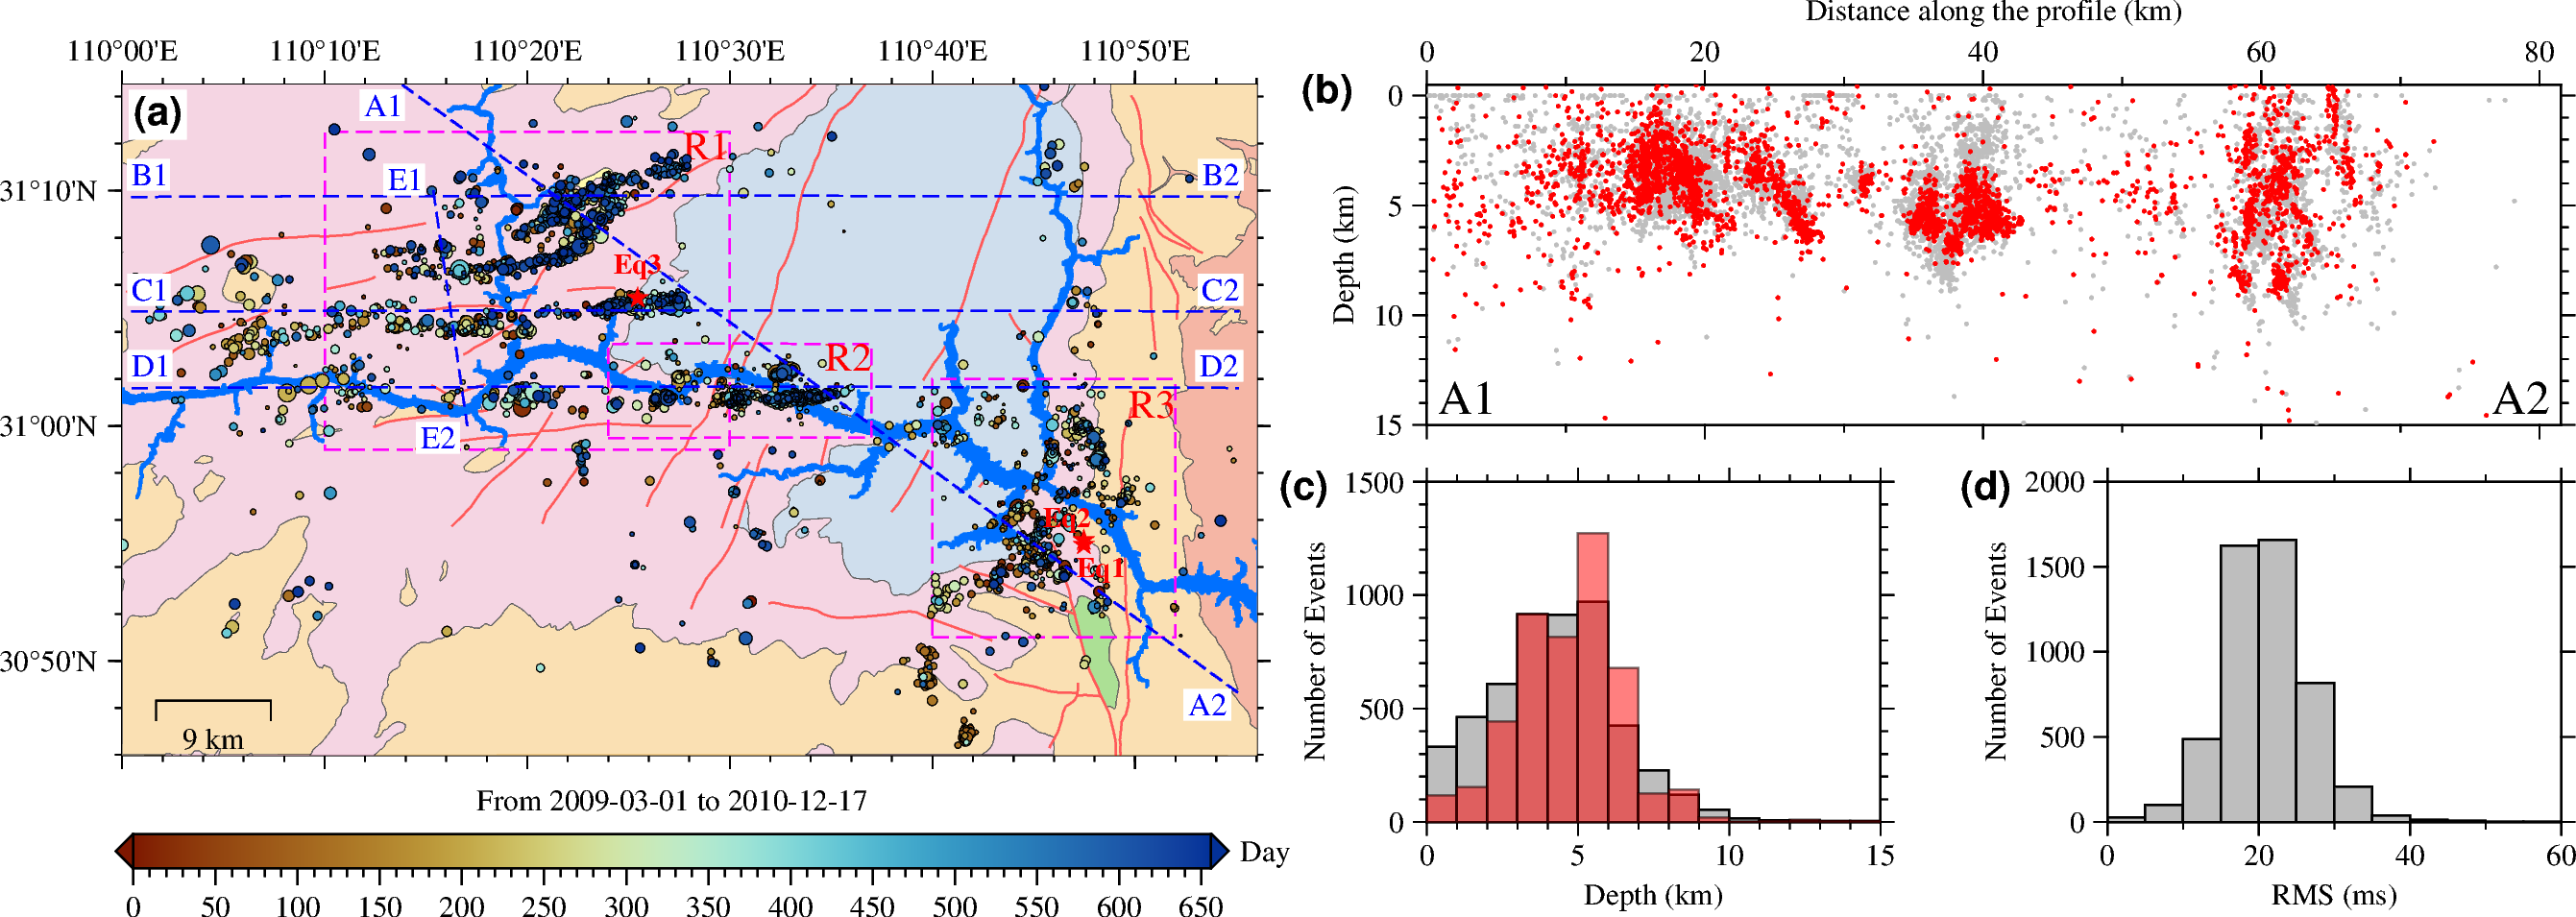

In [18]:
# plot the profile
profile = pygmt.project(data=None,center=[lon_A1,lat_A1],endpoint=[lon_A2,lat_A2],generate=0.01,unit=True)
p_region = [0,profile.iloc[-1]['p'],-0.5,15]
track_reloc = pygmt.project(data=reloc[['longitude','latitude','depth']],center=[lon_A1,lat_A1],endpoint=[lon_A2,lat_A2],length='w',width=None,convention='pzq',unit=True)
track_reloc.columns = ['p','z','q']

track_loc = pygmt.project(data=loc[['longitude','latitude','depth']],center=[lon_A1,lat_A1],endpoint=[lon_A2,lat_A2],length='w',width=None,convention='pzq',unit=True)
track_loc.columns = ['p','z','q']
fig.shift_origin(xshift='11.5',yshift='{}c'.format(map_height-3.0))
#fig = pygmt.Figure()
#pygmt.config(FONT='7.5p,4',MAP_FRAME_TYPE='plain',MAP_FRAME_PEN='0.5p')
fig.basemap(region=p_region,projection='X10c/-3c',frame=['yaf+lDepth (km)','xaf+lDistance along the profile (km)','WseN'])
fig.plot(x=track_loc.p,y=track_loc.z,style='c0.04c',fill='gray')
fig.plot(x=track_reloc.p,y=track_reloc.z,style='c0.04c',fill='red')
fig.text(position='cTL',text='(b)',font='10p,1',offset='j-1.1c/-0.1c',no_clip=True)
fig.text(position='cBL',text='A1',font='12p',offset='+0.1c/0.1c')
fig.text(position='cBR',text='A2',font='12p',offset='-0.1c/0.1c')

fig.shift_origin(yshift='-3.5c')
h_region = [0,15,0,1500]
fig.histogram(data=loc.depth,region=h_region,projection='X4c/3c',series=1,fill='gray',pen='0.5p',histtype=0,
              frame=['xaf+lDepth (km)','yaf+lNumber of Events','WSen'])
fig.histogram(data=reloc.depth,series=1,fill='red',pen='0.5p',histtype=0,transparency=50)
fig.text(position='cTL',text='(c)',font='10p,1',offset='j-1.3c/-0.1c',no_clip=True)

fig.shift_origin(xshift='6c')
fig.histogram(data=reloc.rct*1000,region=[0,60,0,0],projection='X4c/3c',series=5,fill='gray',pen='0.5p',histtype=0,
              frame=['xaf+lRMS (ms)','yaf+lNumber of Events','WSen'])
fig.text(position='cTL',text='(d)',font='10p,1',offset='j-1.3c/-0.1c',no_clip=True)
fig.show()

In [19]:
fig.savefig('plotting_figures'+os.sep+'Figure11_relocation.png',dpi=600)
fig.savefig('plotting_figures'+os.sep+'Figure11_relocation.pdf')

In [20]:
# remove data
for file in glob.glob('*.cpt'):
    os.remove(file)